# CLV Analysis - Main Execution Notebook

This notebook executes all modules from their subpaths for both Lifetimes and Meridian models.


## Setup and Imports


In [1]:
import sys
import os
import numpy as np
import pandas as pd
# Add the project root to Python path
sys.path.insert(0, os.path.abspath('..'))

# Import shared utilities
from src.data_preprocess.data_preprocess_utils import *
from src.model.model_utils import *

# Import model-specific modules
from src.model.lifetimes.models import BGNBDModel, GammaGammaCLVModel, plot_probability_alive_heatmap
from src.model.lifetimes.clv_analysis_poc import *
from src.model.lifetimes.visualization import *

print("All modules imported successfully!")


All modules imported successfully!


## Data Loading and Preprocessing


In [2]:
# Load and preprocess the retail data
DATA_PATH = '/Users/stephenzhang/Downloads/clv_data/Year_2010_2011.csv'

print("Loading retail data...")
df_raw = load_retail_data(DATA_PATH)
print(f"Raw data shape: {df_raw.shape}")
print(f"Columns: {list(df_raw.columns)}")

print("\nCleaning transaction data...")
df_clean = clean_transaction_data(df_raw)
print(f"Cleaned data shape: {df_clean.shape}")

print("\nCreating customer summary for CLV analysis...")
summary = create_customer_summary(df_clean)
print(f"Customer summary shape: {summary.shape}")
print(f"Summary columns: {list(summary.columns)}")

# Display sample of the summary data
print("\nSample customer summary:")
print(summary.head())


Loading retail data...
Raw data shape: (541910, 8)
Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

Cleaning transaction data...
Cleaned data shape: (397885, 9)

Creating customer summary for CLV analysis...
Customer summary shape: (2790, 4)
Summary columns: ['frequency', 'recency', 'T', 'monetary_value']

Sample customer summary:
             frequency  recency      T  monetary_value
Customer ID                                           
12347.0            6.0    365.0  367.0      599.701667
12348.0            3.0    283.0  358.0      301.480000
12352.0            6.0    260.0  296.0      368.256667
12356.0            2.0    303.0  325.0      269.905000
12358.0            1.0    149.0  150.0      683.200000


## Model Fitting and Training


In [3]:
# Fit BG/NBD model for transaction frequency prediction
print("Fitting BG/NBD model for transaction frequency...")
bg_nbd_model = BGNBDModel(penalizer_coef=0.0)
bg_nbd_model.fit(
    frequency=summary['frequency'],
    recency=summary['recency'], 
    T=summary['T']
)
print("✅ BG/NBD model fitted successfully!")
print(f"BG/NBD parameters: {bg_nbd_model.params_}")

# Fit Gamma-Gamma model for monetary value prediction
print("\nFitting Gamma-Gamma model for monetary value...")
gamma_gamma_model = GammaGammaCLVModel(penalizer_coef=0.0)
gamma_gamma_model.fit(
    frequency=summary['frequency'],
    monetary_value=summary['monetary_value']
)
print("✅ Gamma-Gamma model fitted successfully!")
print(f"Gamma-Gamma parameters: {gamma_gamma_model.params_}")


Fitting BG/NBD model for transaction frequency...
✅ BG/NBD model fitted successfully!
BG/NBD parameters: r          1.943039
alpha    108.919779
a          0.009043
b          0.163419
dtype: float64

Fitting Gamma-Gamma model for monetary value...
✅ Gamma-Gamma model fitted successfully!
Gamma-Gamma parameters: p      2.103382
q      3.451306
v    485.915505
dtype: float64


## CLV Predictions and Analysis


In [4]:
# Calculate Customer Lifetime Value predictions
print("Calculating CLV predictions...")

# Predict CLV for next 30 days
clv_30d = gamma_gamma_model.customer_lifetime_value(
    bg_nbd_model=bg_nbd_model,
    frequency=summary['frequency'],
    recency=summary['recency'],
    T=summary['T'],
    monetary_value=summary['monetary_value'],
    time=30,  # 30 days
    freq='D',  # daily frequency
    discount_rate=0.01  # 1% daily discount rate
)

# Predict CLV for next 90 days
clv_90d = gamma_gamma_model.customer_lifetime_value(
    bg_nbd_model=bg_nbd_model,
    frequency=summary['frequency'],
    recency=summary['recency'],
    T=summary['T'],
    monetary_value=summary['monetary_value'],
    time=90,  # 90 days
    freq='D',  # daily frequency
    discount_rate=0.01  # 1% daily discount rate
)

print("✅ CLV predictions calculated successfully!")

# Add CLV predictions to summary dataframe
summary_with_clv = summary.copy()
summary_with_clv['clv_30d'] = clv_30d
summary_with_clv['clv_90d'] = clv_90d

# Display CLV statistics
print(f"\nCLV Statistics (30 days):")
print(f"Mean CLV: £{clv_30d.mean():.2f}")
print(f"Median CLV: £{np.median(clv_30d):.2f}")
print(f"Max CLV: £{clv_30d.max():.2f}")
print(f"Min CLV: £{clv_30d.min():.2f}")

print(f"\nCLV Statistics (90 days):")
print(f"Mean CLV: £{clv_90d.mean():.2f}")
print(f"Median CLV: £{np.median(clv_90d):.2f}")
print(f"Max CLV: £{clv_90d.max():.2f}")
print(f"Min CLV: £{clv_90d.min():.2f}")

# Show top 10 customers by CLV
print(f"\nTop 10 customers by 30-day CLV:")
top_customers = summary_with_clv.nlargest(10, 'clv_30d')[['frequency', 'recency', 'monetary_value', 'clv_30d', 'clv_90d']]
print(top_customers)


Calculating CLV predictions...
✅ CLV predictions calculated successfully!

CLV Statistics (30 days):
Mean CLV: £6411.99
Median CLV: £3573.91
Max CLV: £528249.29
Min CLV: £240.25

CLV Statistics (90 days):
Mean CLV: £14612.92
Median CLV: £8143.85
Max CLV: £1201840.59
Min CLV: £546.83

Top 10 customers by 30-day CLV:
             frequency  recency  monetary_value        clv_30d       clv_90d
Customer ID                                                                 
16446.0            1.0    205.0   168469.600000  528249.293224  1.201841e+06
14646.0           44.0    353.0     6366.705909  474572.306760  1.082760e+06
18102.0           25.0    367.0     9349.477200  389940.051936  8.896401e+05
17450.0           26.0    359.0     7404.690385  320922.853001  7.321838e+05
14096.0           16.0     97.0     4071.434375  250274.489473  5.702093e+05
14911.0          131.0    372.0     1093.661679  231030.774869  5.271823e+05
12415.0           15.0    313.0     7860.210000  213728.700838  4.8

## Probability Alive Analysis


In [5]:
# Calculate probability that customers are still "alive" (active)
print("Calculating probability alive for all customers...")
prob_alive = bg_nbd_model.probability_alive(
    frequency=summary['frequency'],
    recency=summary['recency'],
    T=summary['T']
)

# Add probability alive to summary
summary_with_clv['prob_alive'] = prob_alive

print("✅ Probability alive calculated successfully!")

# Display probability alive statistics
print(f"\nProbability Alive Statistics:")
print(f"Mean probability: {prob_alive.mean():.3f}")
print(f"Median probability: {np.median(prob_alive):.3f}")
print(f"Customers with >90% probability alive: {(prob_alive > 0.9).sum()}")
print(f"Customers with <10% probability alive: {(prob_alive < 0.1).sum()}")

# Show customers with high probability of being alive but low CLV (retention opportunities)
high_prob_low_clv = summary_with_clv[
    (summary_with_clv['prob_alive'] > 0.8) & 
    (summary_with_clv['clv_30d'] < np.median(summary_with_clv['clv_30d']))
].nlargest(10, 'prob_alive')[['frequency', 'recency', 'monetary_value', 'prob_alive', 'clv_30d']]

print(f"\nTop retention opportunities (high prob alive, low CLV):")
print(high_prob_low_clv)


Calculating probability alive for all customers...
✅ Probability alive calculated successfully!

Probability Alive Statistics:
Mean probability: 0.937
Median probability: 0.990
Customers with >90% probability alive: 2312
Customers with <10% probability alive: 0

Top retention opportunities (high prob alive, low CLV):
             frequency  recency  monetary_value  prob_alive      clv_30d
Customer ID                                                             
12877.0           11.0    355.0      125.973636    0.999034  3277.621134
16775.0           10.0    357.0      146.376000    0.998730  3366.720574
16817.0            8.0    366.0      170.068750    0.998686  3226.147129
17961.0           34.0    351.0       34.379118    0.998645  2703.928138
15910.0            7.0    316.0      154.670000    0.998535  3102.896233
15602.0            8.0    360.0      150.665000    0.998509  2954.405733
14083.0            7.0    367.0      101.270000    0.998421  2093.547168
14901.0            8.0  

## Visualization and Reporting


Generating probability alive heatmap...


FileNotFoundError: [Errno 2] No such file or directory: 'data/lifetimes/plots/probability_alive_heatmap.png'

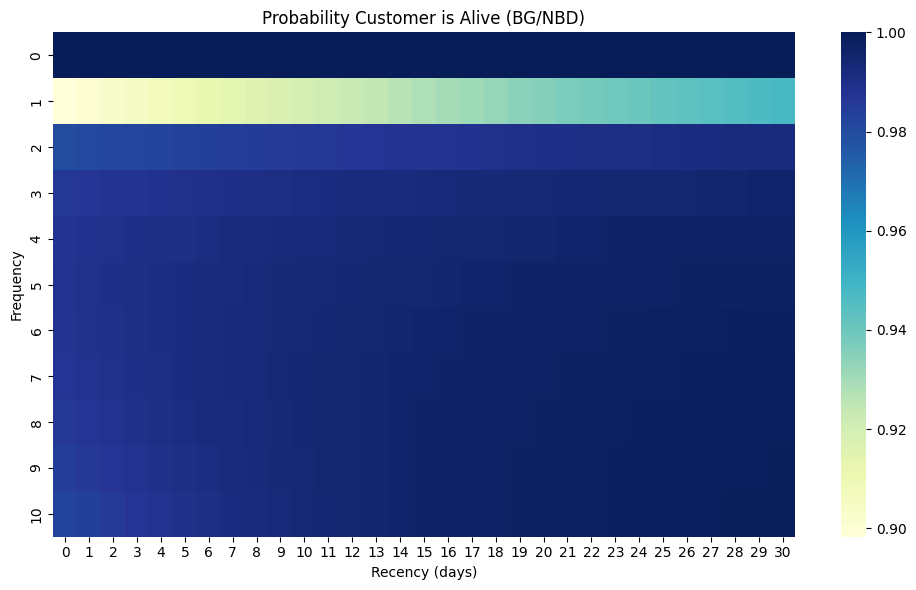

In [ ]:
# Generate probability alive heatmap
print("Generating probability alive heatmap...")

# Ensure the plots directory exists
os.makedirs('data/lifetimes/plots', exist_ok=True)

plot_probability_alive_heatmap(
    bg_nbd_model, 
    max_frequency=10, 
    max_recency=30, 
    T=30, 
    save_path='data/lifetimes/plots/probability_alive_heatmap.png'
)
print("✅ Probability alive heatmap generated!")

# Save results to CSV
output_path = 'data/lifetimes/clv_results_complete.csv'
summary_with_clv.to_csv(output_path, index=True)
print(f"✅ Complete CLV results saved to: {output_path}")

# Generate comprehensive visualization report
print("Generating comprehensive visualization report...")
generate_html_report()
print("✅ HTML visualization report generated!")

print("\n🎉 CLV Analysis Complete!")
print("=" * 50)
print("Summary of outputs:")
print(f"1. Complete CLV results: {output_path}")
print("2. Probability alive heatmap: data/lifetimes/plots/probability_alive_heatmap.png")
print("3. HTML visualization report: data/lifetimes/visualization_report.html")
print("4. All plots saved in: data/lifetimes/plots/")
print("=" * 50)
